In [1]:
# fix python path if working locally
#from utils import fix_pythonpath_if_working_locally
#fix_pythonpath_if_working_locally()

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)

from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)

from darts.metrics import mae, mape, smape, mse, rmse, r2_score
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import (
    Scaler,
    MissingValuesFiller,
    Mapper,
    InvertibleMapper,
)


import logging
logging.disable(logging.CRITICAL)

import warnings
warnings.filterwarnings("ignore")

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

# Define some parameters to use it later
TIME_COL = 'Month'
TARGET_COL = 'Pounds per cow'
TRAIN_SPLIT_RATIO = 0.80

##### READ THE DATA

In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

# read dataset and make a table
data = pd.read_csv('../dataset/MonthlyMilkIncompleteDataset.csv', header=0, parse_dates=[TIME_COL], dayfirst=False)

print(data.info())
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Month           168 non-null    datetime64[ns]
 1   Pounds per cow  155 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.8 KB
None


,Month,Pounds per cow
0,1962-01-01,589.0
1,1962-02-01,561.0
2,1962-03-01,640.0
3,1962-04-01,656.0
4,1962-05-01,727.0
...,...,...
163,1975-08-01,858.0
164,1975-09-01,NaN
165,1975-10-01,NaN
166,1975-11-01,797.0


##### VISUALIZE IMPORTED DATA

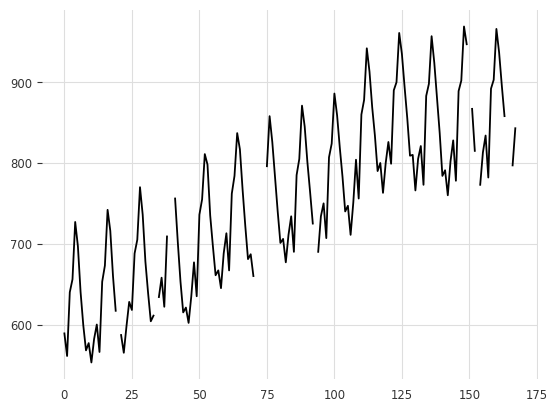

In [3]:
plt.plot(data[TARGET_COL])
plt.show()

##### CONVERT PANDAS DATAFRAME TO DARTS TIMESERIES

In [4]:
import darts
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values

# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(
    data,
    time_col=TIME_COL,
    value_cols=TARGET_COL,
    fill_missing_dates=True,
    freq="MS",  # "M" stands for monthly
)

series

<TimeSeries (DataArray) (Month: 168, component: 1, sample: 1)>
array([[[589.]],

       [[561.]],

       [[640.]],

       [[656.]],

       [[727.]],

       [[697.]],

       [[640.]],

       [[599.]],

       [[568.]],

       [[577.]],

...

       [[892.]],

       [[903.]],

       [[966.]],

       [[937.]],

       [[896.]],

       [[858.]],

       [[ nan]],

       [[ nan]],

       [[797.]],

       [[843.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1962-01-01 1962-02-01 ... 1975-12-01
  * component  (component) object 'Pounds per cow'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

##### FILL EMPTY ROWS WITH MISSING DATA
You can refer to more information about how to deal with missing values on the following links:
- https://unit8co.github.io/darts/generated_api/darts.dataprocessing.transformers.missing_values_filler.html?highlight=interpolation
- https://www.projectpro.io/recipes/deal-with-missing-values-in-timeseries-in-python


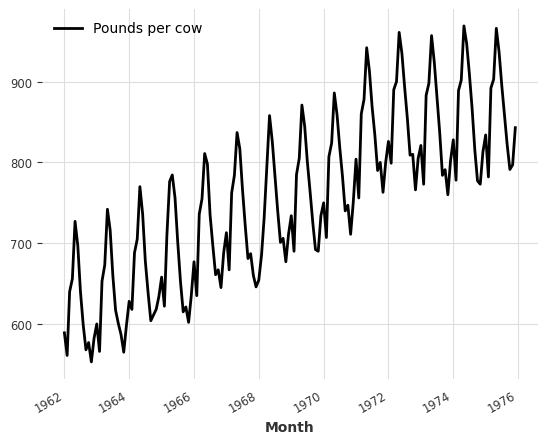

In [5]:
filler = MissingValuesFiller()
series = filler.transform(series, method="quadratic")

series.plot();

##### DATA SEPARATION - MONTHLY

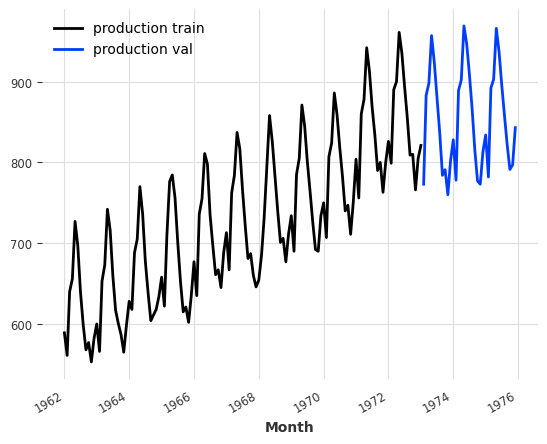

In [6]:
# Split Dataset into Training and Validation sets
train, val = series.split_before(TRAIN_SPLIT_RATIO)
#train, val = series.split_before(pd.Timestamp("1973-01-01"))


train[TARGET_COL].plot(label='production train')
val[TARGET_COL].plot(label='production val');

##### TRANSFORM TIME SERIES VALUES FROM MONTHS TO DAYS
The main problem with analysing data in months is the fact that some months contain more days than others, resulting in a larger production of milk during those months. This makes the time series more complex, and thus harder to predict.

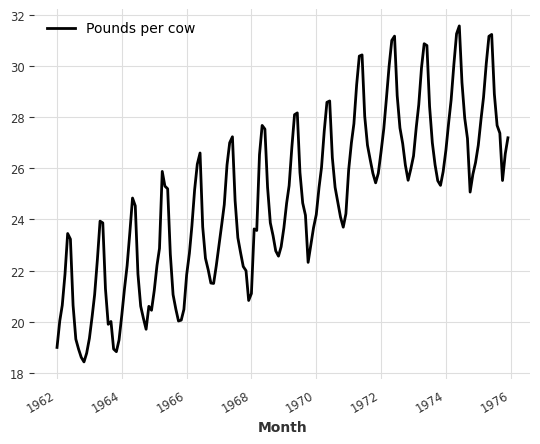

In [7]:
# Transform the time series
toDailyAverage = InvertibleMapper(
    fn=lambda timestamp, x: x / timestamp.days_in_month,
    inverse_fn=lambda timestamp, x: x * timestamp.days_in_month,
)

dailyAverage = toDailyAverage.transform(series)
dailyAverage.plot();

##### PREPROCESSING
Generally, many machine learning algorithms tend to work better on data preprocessed (normalisation/standardization). This block of code will create a MixMax Scaler to normalise these time series to values between 0 and 1

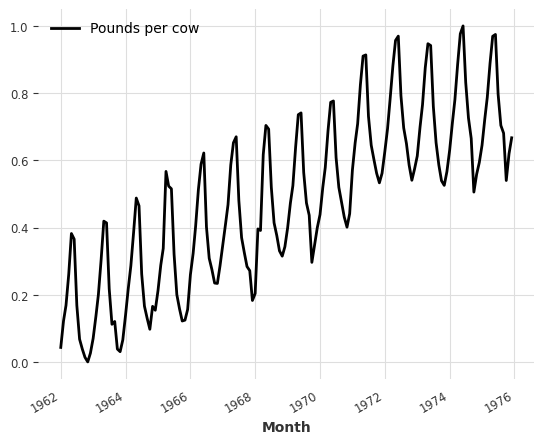

In [8]:
scaler = Scaler()
dailyAverage = scaler.fit_transform(dailyAverage)

dailyAverage[TARGET_COL].plot(label="Pounds per cow")
plt.legend();

##### DATA SEPARATION - DAILY

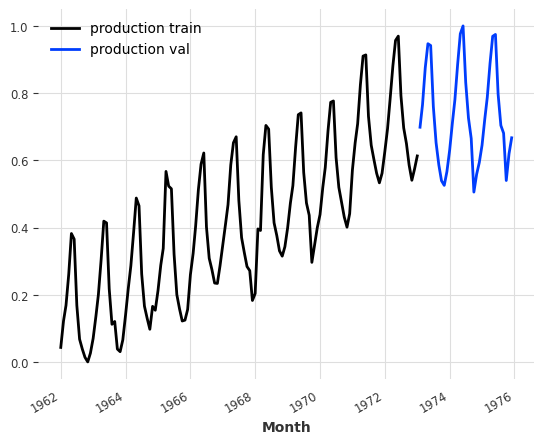

In [9]:
# Split Dataset into Training and Validation sets
dailyavg_train, dailyavg_val = dailyAverage.split_before(TRAIN_SPLIT_RATIO)
#dailyavg_train, dailyavg_val = dailyAverage.split_before(pd.Timestamp("1973-01-01"))


dailyavg_train[TARGET_COL].plot(label='production train')
dailyavg_val[TARGET_COL].plot(label='production val');

##### MODEL TRAINING

In [10]:
%%time

N_PRED = len(dailyavg_val)

parameters = {
    #'trend':[darts.utils.utils.TrendMode('linear'),
    #         darts.utils.utils.TrendMode('exponential')],
    'damped':[False], 
    #'seasonal':[darts.utils.utils.SeasonalityMode('additive'),
    #            darts.utils.utils.SeasonalityMode('multiplicative')], 
    'seasonal_periods':[None], 
    'random_state':[42],
}

# Randomized gridsearch
res = ExponentialSmoothing.gridsearch(
    parameters=parameters,
    series=dailyavg_train,
    val_series=dailyavg_val,
    start=0.1,  # starting point in training set
    last_points_only=False,
    metric=mape,
    reduction=np.mean,
    n_jobs=-1,
    verbose=True,
)

best_model, best_params = res[0], res[1]
best_model.model_params

  0%|          | 0/1 [00:00<?, ?it/s]

Wall time: 6.19 s


OrderedDict([('trend', <ModelMode.ADDITIVE: 'additive'>),
             ('damped', False),
             ('seasonal', <SeasonalityMode.ADDITIVE: 'additive'>),
             ('seasonal_periods', None),
             ('random_state', 42)])

##### MODEL TRAINING

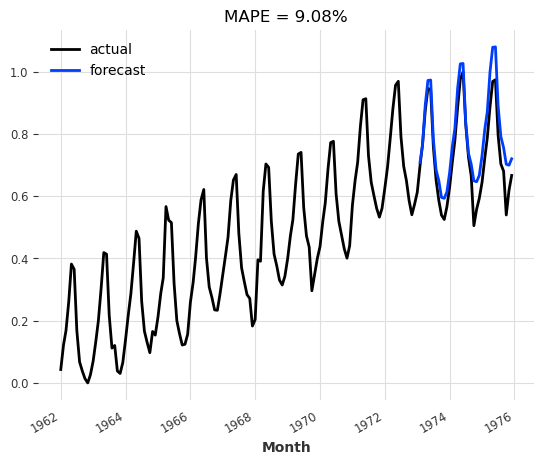

In [11]:
best_model.fit(series=dailyavg_train);

dailyavg_pred = best_model.predict(N_PRED)

dailyAverage.plot(label="actual")
dailyavg_pred.plot(label="forecast")
plt.title("MAPE = {:.2f}%".format(mape(actual_series=dailyavg_val, pred_series=dailyavg_pred)))
plt.legend();

##### TRANSFORM FORECAST RESULT FROM DAILY TO MONTHLY, AND TEST PERFORMANCE

 MSE: 842.2056302222519
 RMSE: 29.02077928351084
 MAE: 24.6597005456183
 MAPE: 2.9324044570507835
 R2: 0.783441536453831


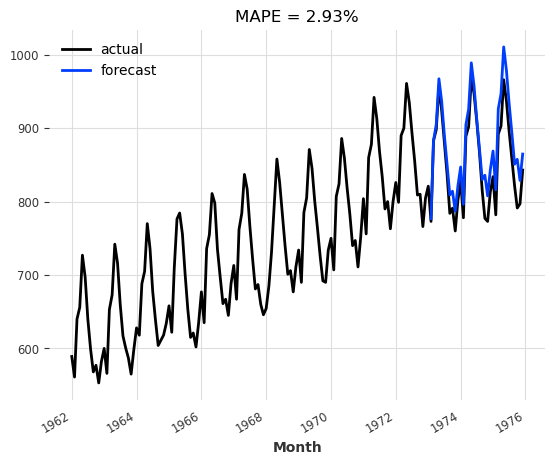

In [12]:
# reverse scaling and convert values back from dayly results to monthly results
dailyavg_pred = scaler.inverse_transform(dailyavg_pred)
pred = toDailyAverage.inverse_transform(dailyavg_pred)

series.plot(label="actual")
pred.plot(label="forecast")
plt.title("MAPE = {:.2f}%".format(mape(actual_series=val, pred_series=pred)))
plt.legend();

# ----- CALCULATE METRICS ------

MSE = mse(actual_series=val, pred_series=pred)
RMSE = rmse(actual_series=val, pred_series=pred)
MAE = mae(actual_series=val, pred_series=pred)
MAPE = mape(actual_series=val, pred_series=pred)
R2 = r2_score(actual_series=val, pred_series=pred)

print(f" MSE: {MSE}\n RMSE: {RMSE}\n MAE: {MAE}\n MAPE: {MAPE}\n R2: {R2}")